# Temporal Correlation Function

To understand how sections of the river change states and how stable each state is, we calculate a correlation function between each pool-state pair

### Imports

In [1]:
import pandas as pd
import pickle as pk
import matplotlib.pyplot as plt
import math
from bisect import bisect
import numpy as np
from datetime import datetime

Fontconfig warning: ignoring UTF-8: not a valid region tag


### Get Scomplex and associated Dataframe for all data output

In [2]:
# This Data Frame should include boolean columns for each state
#df = pk.load(open("LTRM_df.p",'rb'))
df = pd.read_csv(r"LTRM_states.csv")
scomplex = pk.load(open("LTRM_scomplex.p",'rb'))

In [3]:
df.columns

Index(['WDP', 'TEMP', 'DO', 'VEL', 'TP', 'TN', 'SS', 'CHLcal', 'SHEETBAR',
       'DATE', 'LATTITUDE', 'LONGITUDE', 'FLDNUM', 'STRATUM', 'LOCATCD',
       'YEAR', 'SEASON', '1993-2000', '1898-2004', '2001-2013', '2010-2016',
       '2014-2020', 'Backwater area contiguous to the main channel',
       'Impounded', 'Isolated', 'Lake Pepin or Swan Lake', 'Main channel',
       'Side channel', 'Unexploded Ordinance Area - Pool 13', 'Bellevue, IA',
       'Brighton, IL', 'Havana, IL', 'Jackson, MO', 'Lake City, MN',
       'Onalaska, WI', 'WDP_unscaled', 'TEMP_unscaled', 'DO_unscaled',
       'VEL_unscaled', 'TP_unscaled', 'TN_unscaled', 'SS_unscaled',
       'CHLcal_unscaled', 'WDP_color', 'TEMP_color', 'DO_color', 'VEL_color',
       'TP_color', 'TN_color', 'SS_color', 'CHLcal_color', 'State 1',
       'State 3', 'State 2', 'State 4', 'State 5', 'Transition', 'State'],
      dtype='object')

Checking how many points are in each state

In [6]:
states = ["State 1","State 2","State 3","State 4","State 5","Transition"]
for state in states:
    print("Num points in ",state," ",df[state].sum())

Num points in  State 1   143
Num points in  State 2   15420
Num points in  State 3   1150
Num points in  State 4   216
Num points in  State 5   65468
Num points in  Transition   2056


In [7]:
df[(df["State 5"]==1) &(df["Transition"]==1)]

,WDP,TEMP,DO,VEL,TP,TN,SS,CHLcal,SHEETBAR,DATE,...,TN_color,SS_color,CHLcal_color,State 1,State 3,State 2,State 4,State 5,Transition,State


In [8]:
# Change date format so it can be sorted
df["DATE"] = pd.to_datetime(df.DATE)
print("Before removing transition nodes and nodes not in main complex",df.shape)
# Remove data that is not part of the main simplicial complex
df = df[(df["State 1"]==1)|(df["State 2"]==1)|(df["State 3"]==1)|(df["State 4"]==1)|(df["State 5"]==1)]
# Sort by date
df.sort_values(by="DATE",inplace = True)
print("After removing transition nodes and nodes not in main complex",df.shape)
df[["DATE","SEASON"]]


Before removing transition nodes and nodes not in main complex (76669, 58)
After removing transition nodes and nodes not in main complex (74613, 58)


,DATE,SEASON
64789,1993-07-12,2
64790,1993-07-12,2
64791,1993-07-12,2
64792,1993-07-12,2
64793,1993-07-12,2
...,...,...
52342,2020-10-27,3
52343,2020-10-27,3
52344,2020-10-27,3
52345,2020-10-27,3


In [9]:
max([date for date in df["DATE"]])

Timestamp('2020-10-27 00:00:00')

In [10]:
# Just for reference of which months are which seasons ---- WINTER SPLITS THE YEAR
month_toseason = {3:1,4:1,5:1,6:2,7:2,8:2,9:3,10:3,11:3,12:4,1:4,2:4}
df["YEAR"].unique()

array([1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019, 2020])

### Functions

In [11]:
'''
When given a series of points, this function will return
the smoothed continuous version by applying a weighted average to 
'window' number of points around it. The average will be computed by 
using inverse distance from the neighbor points. Arrays x and y must
be the same length.

X: is the sorted list of times
Y: is the discrete value

'''
def IDW_smoothing(t,X,Y,window = 4):
    # Get indices and values of average
    # upper is the index of the nearest greater value
    upper = bisect(X,t)
    
    # Weights to apply to average values
    weights = np.zeros(window)
    # Recorded values of the window points
    values = np.zeros(window)
    # Distances of window points from t
    distances = np.zeros(window)
    
    # Handle beginning and end cases
    if t==0:
        return Y[0]
    if upper == len(X):
        return Y[-1]
    
    # At the beginning or end cases, just smooth based on 2 points
    if upper-(window//2)<0 or upper-1+(window//2)>len(X)-1:
        #print(len(X)-1,upper,X[upper-1],t)
        dist1 = abs(X[upper-1]-t)
        dist2 = abs(X[upper]-t)
        if dist1==0:
            return Y[upper-1]
        elif dist2==0:
            return Y[upper]
        else:
            denominator = 1/dist1+1/dist2
            
            return (Y[upper-1]*(1/dist1)/denominator)+(Y[upper]*(1/dist2)/denominator)

    
    if window%2==0:
        for i in range(window):
            dist = abs(X[i+upper-(window//2)]-t)
            val = Y[i+upper-(window//2)]
            if dist == 0:
                return val
    
            distances[i] = dist
            values[i] = val
        
        denominator = 0
        for dist in distances:
            denominator += 1/dist
        
        for i,dist in enumerate(distances):
            weights[i] = (1/dist)/denominator
                        
        return (sum([weights[i]*values[i] for i in range(window)]))
    
    else:
        raise Exception("Not implemented for odd number window yet")
        
def pandas_smoothing(X,Y,window=4):
    # Make a dataframe
    df = pd.DataFrame({"Time":X,"Value":Y})
    df.sort_values(by="Time",inplace=True)
    
    # Calculate moving average
    df["Moving Avg"] = df.rolling(window,center=True,win_type='gaussian').mean(std=30)
    
    return df

'''
This function applies gaussian smoothing interpolation between points to
smooth out the time series

dates: The times of points recorded (list)
values: The correlation values
window: the number of days to smooth by (how many days forward and backward should affect the smoothed value)?
        default = 60
num_smoothed: Number of points to plot total (recorded points + interpolated points)
        default = 300

'''
def manual_gauss(dates,values,window=60,num_smoothed=300):
    # Make a dataframe
    df = pd.DataFrame({"Time":dates,"Value":values})
    df.sort_values(by="Time",inplace=True)
    
    # Creating new data for smoothing
    begin = df["Time"].iloc[0]
    end = df["Time"].iloc[-1]
    delta = (end-begin)/num_smoothed
    
    # Generate new interpolated dates
    new_X = []
    for i in range(0,num_smoothed+1):
        new_X.append(begin+i*delta)
        
    # Calculate smoothed values for interpolated dates
    new_Y = []
    for date in new_X:
        # Calculate kernel values for this window
        df['gkv'] = np.exp(-(((df['Time'] - date).apply(lambda x: x.days)) ** 2) / (2 * (window ** 2)))
        
        # Scale??
        df['gkv'] /= df['gkv'].sum()
        new_Y.append(sum(df['Value']*df['gkv']))
    
    return pd.DataFrame({"New_X":new_X,"New_Y":new_Y})

'''
This function takes a pool, startyear, then outputs the correlation function for state changes
since this starting year

FLDNUM: The pool we want the correlation function for (string)
startyear: The starting year to plot the function from, always starting in spring of that year
            because winter includes december from last year (int)
            default = 1993
smooth_window: The number of days to smooth the interpolated value by. (how many days forward and backward should affect the smoothed value) (float)
            default = None (no smoothing, points connected by straight lines)

return: The matplotlib axes of the correlation plot
'''
def get_correlation_plot(FLDNUM,startyear=1993,endyear=2021,smooth_window=None):
    # Get the data from this pool and sort by date
    pool_sorted = df[(df.FLDNUM==FLDNUM)&(df.YEAR>=startyear)&(df.YEAR<=endyear)].copy()
    
    # Get the starting season for this dataframe
    start_month = pool_sorted["DATE"].iloc[0].month
    start_szn = month_toseason[start_month]
    
    # Dates for plotting on x axis (pd.Timestamps)
    dates = []

    # Lists for proportions of points in each state
    State1 = []
    State2 = []
    State3 = []
    State4 = []
    State5 = []
    
    year = startyear
    season = start_szn
    # Get state proportions for each "snapshot" in time
    while year >= min(pool_sorted["YEAR"]) and year <= max(pool_sorted["YEAR"]):
        # Get snapshot
        if season!=4:
            snap_df = pool_sorted[(pool_sorted["YEAR"]==year)&(pool_sorted["SEASON"]==season)]
        else:
            # Handle winter splitting up the years
            begin_szn = pd.Timestamp(year=year,month=12,day=1)
            end_szn = pd.Timestamp(year=year+1,month=3,day=1)
            snap_df = pool_sorted[(pool_sorted["DATE"]>begin_szn)&(pool_sorted["DATE"]<end_szn)]

        # Average dates in this period
        date = snap_df["DATE"].mean()
        
        # If there is no data in this year and season, skip it
        if snap_df.shape[0]==0:
            print("No data for ",year," ",season)
            season+=1
            # Reset szn to spring if it was winter
            if season==5:
                season = 1
                year += 1
            continue

        # Check which states these points are in
        S1 = snap_df["State 1"].sum()
        S2 = snap_df["State 2"].sum()
        S3 = snap_df["State 3"].sum()
        S4 = snap_df["State 4"].sum()
        S5 = snap_df["State 5"].sum()
        
        # Possibly checking state transitions?
        #if S2>S1 or S3>S1:
        #    print("Date of transition: ",date)
            
        # Find the ratio of the points in this "snapshot" that are in each state
        State1.append(float(S1/snap_df.shape[0]))
        State2.append(float(S2/snap_df.shape[0]))
        State3.append(float(S3/snap_df.shape[0]))
        State4.append(float(S4/snap_df.shape[0]))
        State5.append(float(S5/snap_df.shape[0]))


        
        # Add this date to the list for plotting
        dates.append(date)
            
        # Check to increment year
        if season==4:
            year+=1
            season=1
        else:
            season+=1
    
    # Initialize figure for plotting
    fig = plt.figure(figsize=(10,7))

    plt.title(FLDNUM,size=20)
    ax = plt.subplot()
    
    # Plot recorded values of correlation function
    print(type(dates[0]))
    print(type(State1[0]))
    
    ax.scatter(dates,State1,color="blue",s=10)
    ax.scatter(dates,State2,color="red",s=10)
    ax.scatter(dates,State3,color="green",s=10)
    ax.scatter(dates,State4,color="orange",s=10)
    ax.scatter(dates,State5,color="purple",s=10)
    
    
    plt.xlabel("Date")
    plt.ylabel("Correlation")
    
    if smooth_window:
        # Calculate gaussian smoothing
        df1 = manual_gauss(dates,State1,smooth_window)
        df2 = manual_gauss(dates,State2,smooth_window)
        df3 = manual_gauss(dates,State3,smooth_window)
        df4 = manual_gauss(dates,State4,smooth_window)
        df5 = manual_gauss(dates,State5,smooth_window)
        line1, = ax.plot(df1.iloc[:,0],df1.iloc[:,1],color="blue")
        line2, = ax.plot(df2.iloc[:,0],df2.iloc[:,1],color="red")
        line3, = ax.plot(df3.iloc[:,0],df3.iloc[:,1],color="green")
        line4, = ax.plot(df4.iloc[:,0],df4.iloc[:,1],color="orange")
        line5, = ax.plot(df5.iloc[:,0],df5.iloc[:,1],color="purple")
        
    else:
        # Connect recorded points with straight line
        line1, = ax.plot(dates,State1,color="blue")
        line2, = ax.plot(dates,State2,color="red")
        line3, = ax.plot(dates,State3,color="green")
        line4, = ax.plot(dates,State4,color="orange")
        line5, = ax.plot(dates,State5,color="purple")
        
    # Shrink current axis by 20%
    #box = ax.get_position()
    #ax.set_position([box.x0, box.y0, box.width * , box.height])
    
    # Changed in correspondance to Alaina's state definitions
    plt.legend(handles=[line1,line2,line3,line4,line5],labels=["State 5","State 1","State 3","State 4","State 2"]
              ,bbox_to_anchor=(1.15, 1))
              
    plt.show()
    return fig

print("Functions Loaded")

Functions Loaded


Testing the average length of time that is condensed into 1 time t

In [10]:
num_snaps = 0
total_ranges = pd.Timedelta("0 days")
year = 1993
season = 2
while year >= min(df["YEAR"]) and year <= max(df["YEAR"]):
    # Get snapshot
    if season!=4:
        snap_df = df[(df["YEAR"]==year)&(df["SEASON"]==season)]
    else:
        # Handle winter splitting up the years
        begin_szn = pd.Timestamp(year=year,month=12,day=1)
        end_szn = pd.Timestamp(year=year+1,month=3,day=1)
        snap_df = df[(df["DATE"]>begin_szn)&(df["DATE"]<end_szn)]
                
    # If there is no data in this year and season, skip it
    if snap_df.shape[0]==0:
        print("No data for ",year," ",season)
        season+=1
        # Reset szn to spring if it was winter
        if season==5:
            season = 1
            year += 1
        continue
    
    time_range = max(snap_df["DATE"])-min(snap_df["DATE"])
        
    # Check to increment year
    if season==4:
        year+=1
        season=1
    else:
        season+=1
        
    num_snaps += 1
    total_ranges += time_range

No data for  1995   4
No data for  2002   3
No data for  2002   4
No data for  2003   1
No data for  2003   2
No data for  2003   3
No data for  2020   4


In [11]:
total_ranges/num_snaps

Timedelta('15 days 12:13:50.769230')

Each point on the corelation graph represents a data worth 15 days

Each time t on average represents 15 days. We also want to know how many datapoints on average is collected to represent this "snapshot"

In [12]:
num_snaps = 0
num_points = 0

for fldnum in df["FLDNUM"].unique():
    year = 1993
    season = 2
    pool_df = df[df["FLDNUM"]==fldnum]
    while year >= min(df["YEAR"]) and year <= max(df["YEAR"]):
        # Get snapshot
        if season!=4:
            snap_df = pool_df[(pool_df["YEAR"]==year)&(pool_df["SEASON"]==season)]
        else:
            # Handle winter splitting up the years
            begin_szn = pd.Timestamp(year=year,month=12,day=1)
            end_szn = pd.Timestamp(year=year+1,month=3,day=1)
            snap_df = pool_df[(pool_df["DATE"]>begin_szn)&(pool_df["DATE"]<end_szn)]

        # If there is no data in this year and season, skip it
        if snap_df.shape[0]==0:
            print("No data for ",year," ",season)
            season+=1
            # Reset szn to spring if it was winter
            if season==5:
                season = 1
                year += 1
            continue


        # Check to increment year
        if season==4:
            year+=1
            season=1
        else:
            season+=1

        num_snaps += 1
        num_points += int(snap_df.shape[0])

No data for  1994   3
No data for  1995   4
No data for  2002   3
No data for  2002   4
No data for  2003   1
No data for  2003   2
No data for  2003   3
No data for  2012   1
No data for  2020   1
No data for  2020   4
No data for  1994   3
No data for  1995   4
No data for  2002   3
No data for  2002   4
No data for  2003   1
No data for  2003   2
No data for  2003   3
No data for  2020   1
No data for  2020   4
No data for  1994   3
No data for  1995   4
No data for  2002   3
No data for  2002   4
No data for  2003   1
No data for  2003   2
No data for  2003   3
No data for  2020   1
No data for  2020   4
No data for  1994   3
No data for  1995   4
No data for  2002   3
No data for  2002   4
No data for  2003   1
No data for  2003   2
No data for  2003   3
No data for  2020   4
No data for  1993   2
No data for  1994   3
No data for  1994   4
No data for  1995   4
No data for  2002   3
No data for  2002   4
No data for  2003   1
No data for  2003   2
No data for  2003   3
No data fo

In [13]:
num_points/num_snaps

122.11620294599018

Each snapshot at time t condenses on average 122 datapoints into account to determine the states of the pool.

## Jackson, MO

get_correlation_plot(FLDNUM,startyear=1993,endyear=2021,smooth_window=None)

No data for  2020   4
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'float'>


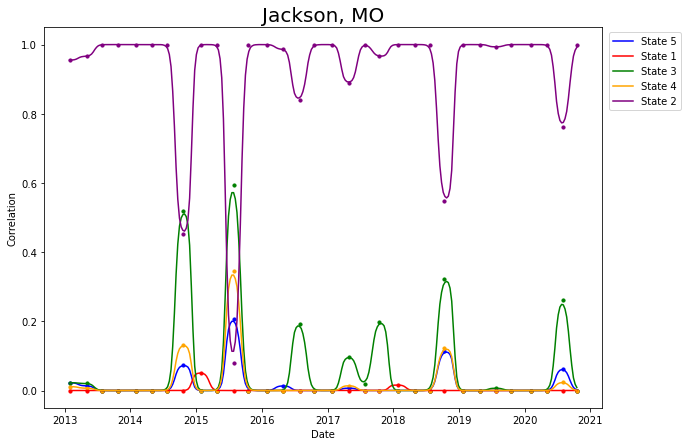

In [12]:
fig = get_correlation_plot("Jackson, MO",startyear=2012,smooth_window=30)

## Havana, IL

No data for  2012   1
No data for  2020   1
No data for  2020   4
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'float'>


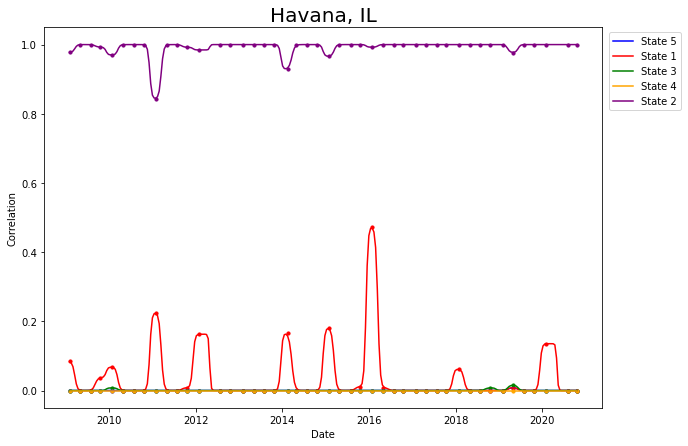

In [13]:
fig = get_correlation_plot("Havana, IL",startyear=2008,smooth_window=30)

## Onalaska, WI

No data for  2020   1
No data for  2020   4
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'float'>


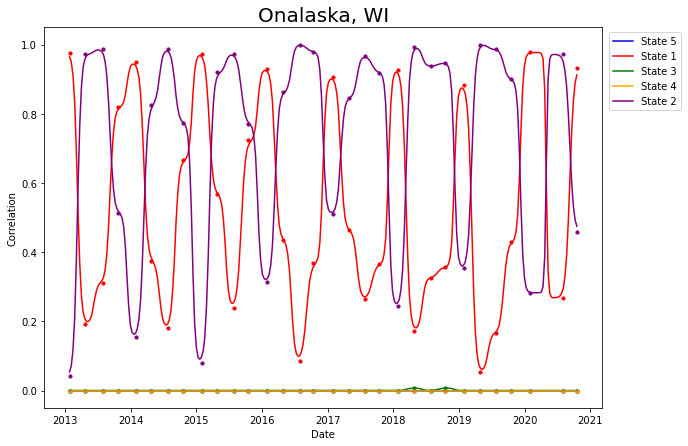

In [14]:
fig = get_correlation_plot("Onalaska, WI",startyear=2012,smooth_window=30)

In [15]:
sub = df[(df["State 2"]==1)|(df["State 1"]==1)]
sub.shape

(15563, 58)

## Lake City, MN

No data for  2020   1
No data for  2020   4
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'float'>


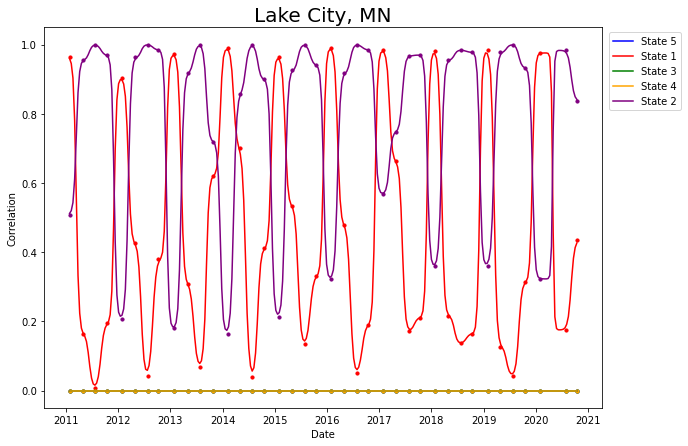

In [16]:
fig = get_correlation_plot("Lake City, MN",startyear=2010,smooth_window=30)

## Bellevue, IA

No data for  2020   4
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'float'>


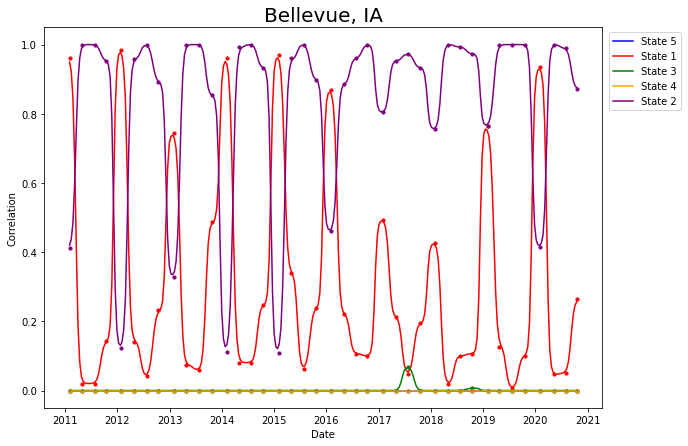

In [17]:
fig = get_correlation_plot("Bellevue, IA",startyear=2010,smooth_window=30)

## Brighton, IL

No data for  1995   4
No data for  2002   3
No data for  2002   4
No data for  2003   1
No data for  2003   2
No data for  2003   3
No data for  2020   1
No data for  2020   4
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'float'>


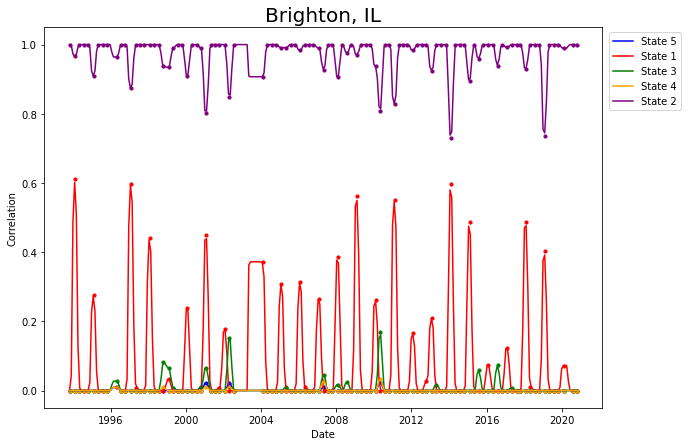

In [18]:
fig = get_correlation_plot("Brighton, IL",smooth_window=30)

In [19]:
df["FLDNUM"].unique()

array(['Havana, IL', 'Onalaska, WI', 'Lake City, MN', 'Bellevue, IA',
       'Jackson, MO', 'Brighton, IL'], dtype=object)

#### Possible error in appending states to dataframe?
There are datapoints that are not assigned to any state, possibly these points were lost to noise

In [20]:
unique = set()
for node in scomplex['nodes']:
    unique.update(scomplex['nodes'][node])
num_unique = len(unique)
df.shape[0]-num_unique

2768

In [21]:
df.loc[unique]

KeyError: '[63598] not in index'

In [22]:
odd = pool_sorted
no_state = odd[(odd["State 1"]==0)&(odd["State 2"]==0)&(odd["State 3"]==0)]
no_state

NameError: name 'pool_sorted' is not defined

In [23]:
# This is checking to see if the points not assigned to a state exist within the scomplex
mystery_nodes = set()
for i in no_state.index:
    for node in scomplex["nodes"]:
        if i in scomplex['nodes'][node]:
            foundnode = node
            mystery_nodes.add(foundnode)
            print("found node: ",foundnode)
            break
        
    for state in scomplex['states']:
        if foundnode in scomplex['states'][state]:
            print(i," in state ",state)
            break

NameError: name 'no_state' is not defined

In [187]:
mystery_nodes

{'cube203_cluster0',
 'cube236_cluster0',
 'cube269_cluster0',
 'cube413_cluster0'}

So these nodes are not in any state? How could this be?

I realized these nodes are not part of the main simplicial complex. I should remove these datapoints at the beginning.

In [3]:
from platform import python_version

In [4]:
python_version()

'3.7.13'

In [5]:
pip show matplotlib

Name: matplotlib
Version: 3.5.1
Summary: Python plotting package
Home-page: https://matplotlib.org
Author: John D. Hunter, Michael Droettboom
Author-email: matplotlib-users@python.org
License: PSF
Location: /Users/wbungula/anaconda3/lib/python3.7/site-packages
Requires: cycler, fonttools, kiwisolver, numpy, packaging, pillow, pyparsing, python-dateutil
Required-by: scikit-bio, scikit-image, seaborn
Note: you may need to restart the kernel to use updated packages.


In [4]:
import matplotlib
print(matplotlib.__version__)

3.1.3


In [3]:
print(pd.__version__)

1.0.1
